n1 = 5, n2 = 9 th = 0.95

Merging Technique on hough lines
Determine lines on remaining CC of subset 1

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math


from Processing import *
from ImageHandler import *
from GeometryProcessing import *
from ImageProcessing import *
from globalVar import *

In [2]:
rcParams['figure.figsize'] = 14, 28

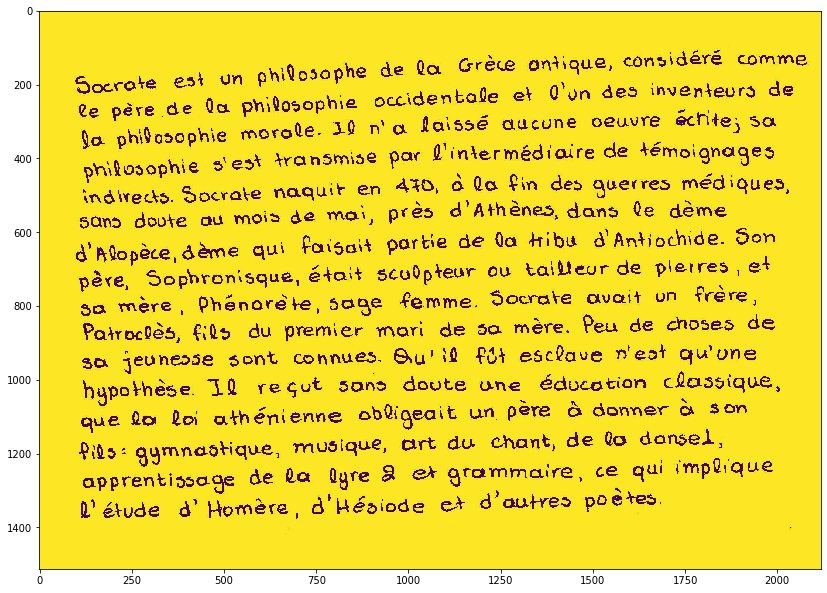

In [26]:
image = loadImage('../icdar/103.jpg')
plt.imshow(image);

In [27]:
# Find components and calc avg height of components, assume it equal to avg character width.
# Divide components into 3 subsets based on simple conditions

(labels, avg_height, centroids, stats) = findComponents(image)
((centroids1, stats1), (centroids2, stats2), (centroids3, stats3)) = divide(centroids, stats, avg_height);

'Found 1318 components with height 24.196509863429437 in image'

'Found 886 in subset 1, 1 in subset 2, and 431 in subset 3'

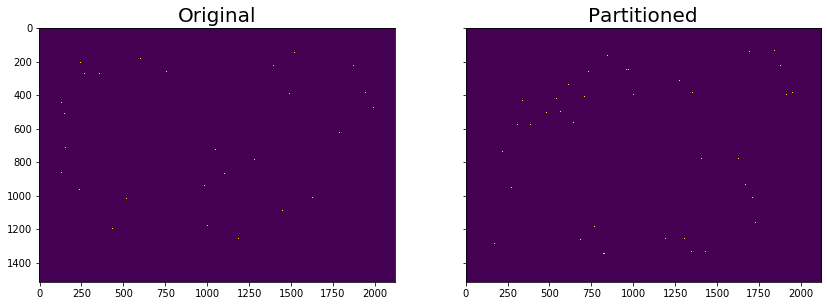

In [28]:
# Divide subset1 components into blocks of width aw and find their centroid. 

centroidP, mapP = partitionCC(stats1, int (avg_height));

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 28), sharex=True, sharey=True)

ax = axes.ravel()
ax[0].imshow(showCentroids(image, centroids1));
ax[0].set_title('Original', fontsize=20);

ax[1].imshow(showCentroids(image, centroidP));
ax[1].set_title('Partitioned', fontsize=20);

66 90


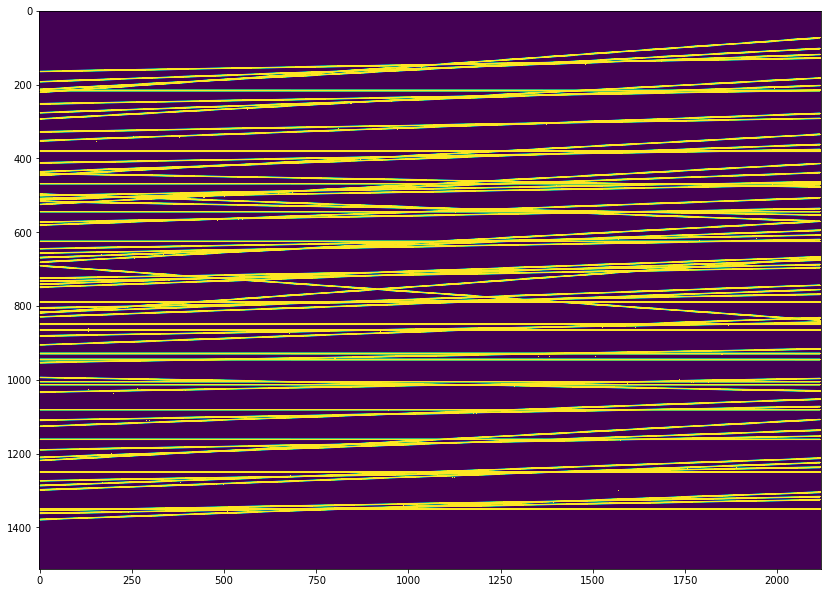

In [29]:
# Perform Hough transform on this with given parameters.
lines = [];
threshold = 10;
while (len(lines) < 4 or len(lines) > 70) and threshold < 500:
    lines = findHoughLines(showCentroids(image, centroidP), None, avg_height, threshold, 10, 40)
    threshold += 5;
if len(lines) < 4 and len(lines) > 100:
    print ('Empty')
    
print (len(lines), threshold);
init(lines, centroidP);

In [ ]:
### Make a lookup array mapping partition to its cc
# Check dist of partition from primary line
# Find the CC of that partition from mapping
# If dist of that partition is within +-0.5p then increment value of that CC else decrement
# Discard all CC having +ve value and map to find partition being discarded
# repeat step unless max contri cell < n1
# if n2 > conti > n1, then cell must be within 2 degree from first found cell.

n = 1000;
selLines = [];
while (True):
    lineP, pos, n = findPrimaryCell(lines, centroidP);
    print ("\rContribution of " + str(n), end= " by this line ");
    if n < 5:
        break;
    elif n < 9:
        pTheta = math.radians(selLines[0][1]);
        theta = math.radians(lineP[1]);
        if (not (theta <= pTheta + 2 and theta >= pTheta - 2)):
            continue;
        print ("Low Contribution " + str(n), end = " ");
    
    centroidPN, count = discardPartition(lineP, np.copy(centroidP), centroids1, mapP)
    
    if (count == 0):
        break;
    
    print ("Discarded " + str(count) + " centroids");
    
    centroidP = np.copy(centroidPN);
    selLines.append(lineP);

print ("\n" + str(len(selLines)) + " lines selected");

In [22]:
count, nl = getIntersectionsH(selLines, image)
print (count);

20


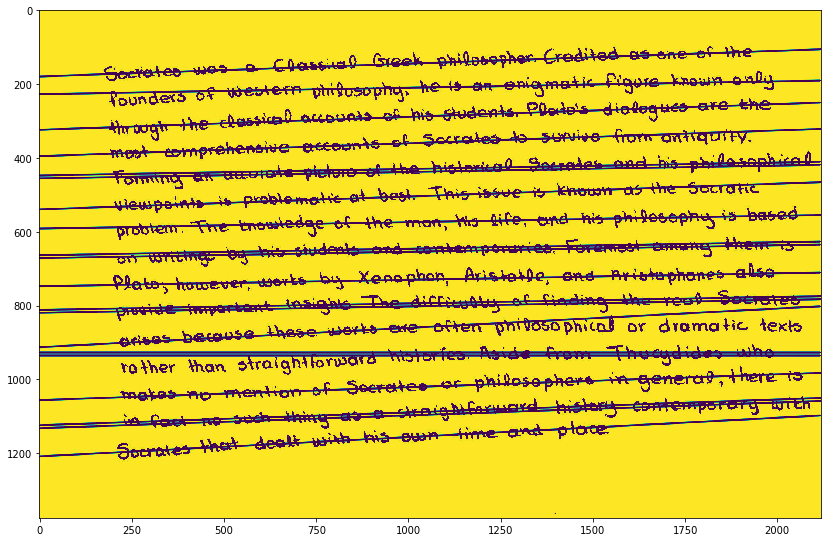

In [25]:
showLines(nl, np.copy(image))

In [19]:
def getLineH(line):
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a)))
    pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a)))
    return Line(pt1, pt2);

def isAdjacent(linei, linej):
    startLine = Line((0,0),(0,100));
    (_, yi) = linei.intersection(startLine)[0];
    (_, yj) = linej.intersection(startLine)[0];

    if abs(yi-yj) < 100:
        return True;
    else:
        return False;

def getIntersectionsH(lines, image):
    (h, w) = np.shape(image);
    Slines = []
    nlines = [];
    for line in lines:
        Slines.append(getLineH(line));

    lineProcessed = [];
    distances = [];
    count = 0;
    for i in range(len(Slines)):
        if i in lineProcessed:
            continue;
        lineProcessed.append(i);
        count += 1;
        nlines.append(lines[i]);
        for j in range(len(Slines)):
            if j in lineProcessed:
                continue;

            linei = Slines[i];
            linej = Slines[j];
            if isAdjacent(linei, linej):
                inter = linei.intersection(linej);
                if inter != []:
                    inter = inter[0];
                else:
                    continue
                if inter.x < w and inter.x > 0:
                    lineProcessed.append(j);
                    distances.append( int(inter.distance(Point(w/2, inter.y))));

    return count, nlines;
